In [37]:
import sys
sys.path.insert(0, "src/")
import matplotlib
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from colors import color
import sklearn as sl
import skimage
from sklearn.metrics import mean_squared_error as MSE
from data import Sample, smooth, Spectra
from scipy.optimize import basinhopping
from camera import CameraCalibration
from tmm.tmm_core import coh_tmm, unpolarized_RT
import copy
import os
from scipy.integrate import trapz
from data import SpectraTheory, SyntheticSpectra, SampleArray, AttributeDict
from camera import CameraCalibration
from collections import defaultdict
from skimage.color import label2rgb
import dill as pickle
from skimage import measure
from scipy.ndimage import gaussian_filter

In [38]:
DATA = 'data/'
METADATA = 'metadata/'

In [39]:
cost_function=MSE
mats_dir='mats/'
data_Si=np.loadtxt(mats_dir+'Si.txt')
data_PMMA=np.loadtxt(mats_dir+'PMMA_nam_dispersion.txt')
wl, n, k = data_Si[:,0], data_Si[:,1], data_Si[:,2]
Si_n= interp1d(wl, n)
Si_k= interp1d(wl, k)
wl, n = data_PMMA[:,0], data_PMMA[:,1]
PMMA_n= interp1d(wl, n)
wavels = np.linspace(405, 740, 70)

def PMMA_n_extr(wl0):
    # Problem: PMMA refractive index defined only from 405nm. Solution:
    try:
        x = PMMA_n(wl0)
    except ValueError:
        x = PMMA_n(405.0)
    return x

def get_refl(wl0,d,n=PMMA_n_extr):
    nk_list = [1,n(wl0),1]
    d_list=[np.inf,d,np.inf]
    return coh_tmm('s', nk_list, d_list, 0, wl0)['R']

def plot_spectra(d, **kargs):
    intensities = [get_refl(wl,d) for wl in wavels]
    plt.plot(wavels, intensities, **kargs)

def myfun_n_color(d, n, RGB, camera:CameraCalibration):
    _, spectra = refl.get_refl(d,n)
    #spectra = np.zeros_like(wavels)
    y_pred = camera.spectra_to_XYZ(wavels,spectra)
    y_true = RGB
    return cost_function(y_true, y_pred)

def myfun_same_n_color(n, samples, camera:CameraCalibration, dmin=50,dmax=700, dn=300):
    ds = np.linspace(dmin,dmax,dn)
    cost_functions = np.zeros((len(samples),len(ds)))
    thicknesses = np.zeros(len(samples))
    for i, sample in enumerate(samples):
        tmp = [myfun_n_color(d,n,sample,camera) for d in ds]
        cost_functions[i]=tmp
        thicknesses[i]=ds[np.argmin(tmp)]
    return cost_functions, thicknesses

camera = CameraCalibration.load(METADATA + 'camera_lu_final.npy')
wl = np.linspace(400,800,100)

In [40]:
class FReflection():
    def __init__(self, reflection_arr, ds, nlist, wavels):
        self.reflection = reflection_arr
        self.ds = ds
        self.nlist = nlist
        self.wavels = wavels
        
    def get_refl(self, d, n):
        idx_n = np.argmin(np.abs(self.nlist-n))
        idx_d = np.argmin(np.abs(self.ds-d))
        return (self.wavels, self.reflection[idx_d,idx_n])
        
    
    @classmethod
    def compute(cls,ds,nlist,wavels):
        reflection = np.zeros([len(ds),len(nlist),len(wavels)])
        for i, d in enumerate(ds):
            for j, n in enumerate(nlist):
                reflection[i,j,:] = [get_refl(wl, d, lambda x: n) for wl in wavels]
        return cls(reflection, ds, nlist, wavels)
    
    @classmethod
    def load(cls,fname='precomputed_reflection.npy'):
        with open(fname,'rb') as file:
            cls_object = pickle.load(file)
        return cls_object
    
    def save(self,fname='precomputed_reflection.npy'):
        with open(fname,'wb') as file:
            pickle.dump(self,file)

ds = np.linspace(50,1200,700)
nlist = np.linspace(1.2,3.0,600)
#refl = FReflection.compute(ds,nlist,wavels)

In [41]:
refl = FReflection.load(METADATA + 'n_precomputed_refr.npy')

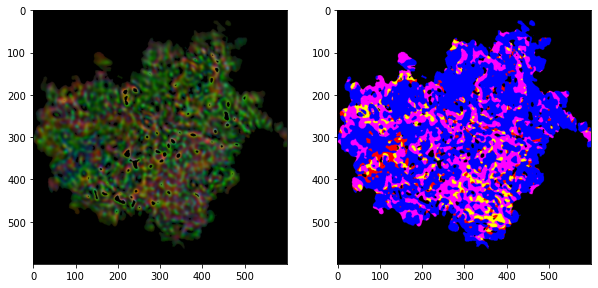

In [70]:
REMOVE_BG_COLOR = False
labels = np.load(METADATA + 'cancer_luv_labels_final.npy')
n_clusters = np.max(labels)
colors = np.load(METADATA + 'cancer_rgb_colors_luv_final.npy')
bg_mask = colors == 0
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(colors)
plt.subplot(122)
plt.imshow(label2rgb(labels,bg_label=0))
plt.show()

300 300


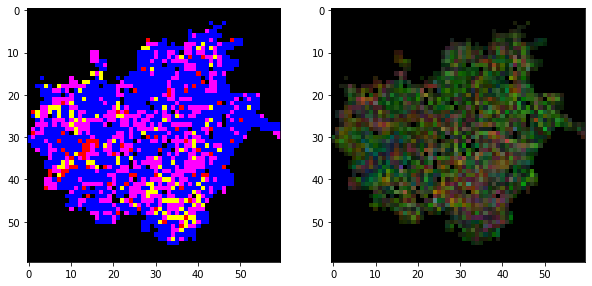

In [71]:
wx, wy = colors.shape[:2]
dx = wx // 2
dy = wy // 2
xc = wx // 2
yc = wy // 2
print(xc,yc)
skip = 10

cut_x = [xc-dx,xc+dx]
cut_y = [yc-dy,yc+dy]
x_crop = slice(cut_x[0],cut_x[1], skip)
y_crop = slice(cut_y[0],cut_y[1], skip)

labels = labels[x_crop,y_crop]
colors = colors[x_crop,y_crop]

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(label2rgb(labels,bg_label=0))
plt.subplot(122)
plt.imshow(colors)
plt.show()

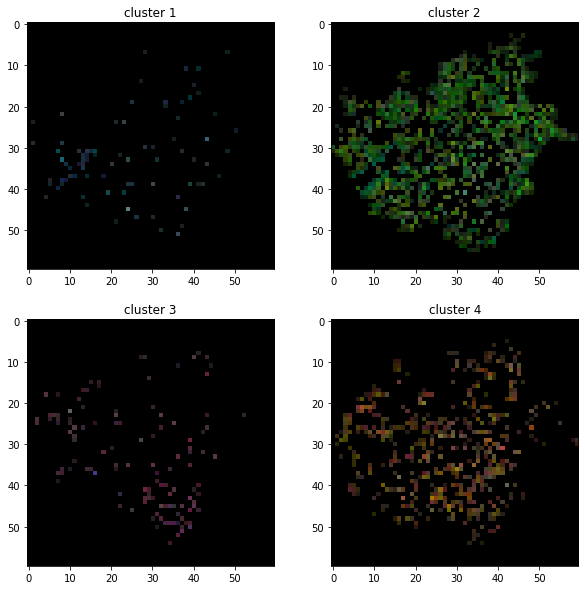

In [72]:
def show_cluster(labels, colors=None, cluster=1, ax=None):
    if ax is None:
        ax = plt.gca()
    labels = labels.copy()
    mask = labels == cluster
    labels[~mask] = 0
    if colors is None:
        ax.imshow(labels)
    else:
        colors = colors.copy()
        colors[~mask] = 0
        ax.imshow(colors)

fig, axes = plt.subplots(2,2,figsize=[10,10])
show_cluster(labels,colors,cluster=1)
for i, ax in enumerate(axes.flatten(),1):
    ax.set_title('cluster %d' % i)
    show_cluster(labels,colors,cluster=i,ax=ax)

In [73]:
bg_mask = labels == 0
cluster_masks = []
for cluster in range(1,labels.max()+1):
    mask = labels[~bg_mask] == cluster
    cluster_masks.append(mask)
samples = colors[~bg_mask]

In [74]:
%%time
import multiprocessing as mp
def processn(i):
    print("I'm process", os.getpid())
    
def cost_n(i,n):
    processn(i)
    return myfun_same_n_color(n, samples,camera)

ds = np.linspace(50,700,300)
nlist = np.linspace(1.1,2.5,96)
cost_functions = np.zeros([len(nlist), len(samples), len(ds)])
thicknesses = np.zeros([len(nlist), len(samples)])
# for i, n in enumerate(nlist):
#     cost_functions[i], thicknesses[i] = myfun_same_n_color(lambda x: n, samples,camera)

pool = mp.Pool(mp.cpu_count())
result_objects = [pool.apply_async(cost_n, args=[j,n])for j, n in enumerate(nlist)]
results = [r.get() for r in result_objects]
pool.close()
pool.join()

for i, (cf, tk) in enumerate(results):
    cost_functions[i] = cf
    thicknesses[i] = tk

I'm process 18689
I'm process 18694
I'm process 18690
I'm process 18692
I'm process 18695
I'm process 18691
I'm process 18697
I'm process 18698
I'm process 18705
I'm process 18708
I'm process 18699
I'm process 18693
I'm process 18706
I'm process 18709
I'm process 18710
I'm process 18696
I'm process 18711
I'm process 18712
I'm process 18707
I'm process 18702
I'm process 18700
I'm process 18703
I'm process 18701
I'm process 18704
I'm process 18712
I'm process 18711
I'm process 18709
I'm process 18708
I'm process 18710
I'm process 18705
I'm process 18707
I'm process 18704
I'm process 18706
I'm process 18703
I'm process 18700
I'm process 18701
I'm process 18702
I'm process 18698
I'm process 18699
I'm process 18697
I'm process 18695
I'm process 18696
I'm process 18692
I'm process 18693
I'm process 18694
I'm process 18691
I'm process 18690
I'm process 18689
I'm process 18712
I'm process 18711
I'm process 18709
I'm process 18710
I'm process 18708
I'm process 18705
I'm process 18707
I'm proces

0.537641229681


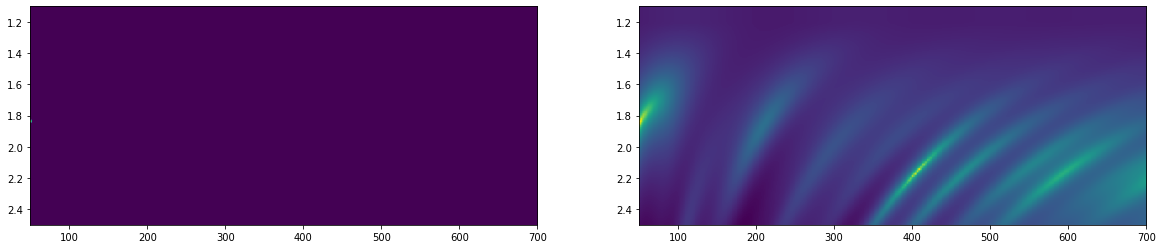

In [75]:
def get__mask(values, argument, sigma):
    return (values>=(values[argument]-sigma)) & (values<=(values[argument]+sigma))

def confidence2d(cost, ds, nlist, sigma_n = 0.1, sigma_d = 25, th=0.8):
    tmp = cost.copy()
    conf = -np.log(tmp)
    mask = conf < conf.max() * th
    conf[mask] = 0
    conf_min = np.unravel_index(conf.argmax(),conf.shape)
    n_indices = get__mask(nlist,conf_min[0],sigma=sigma_n)
    ds_indices = get__mask(ds,conf_min[1],sigma=sigma_d)
    C = conf.sum()
    C1 = conf[n_indices,:][:,ds_indices].sum()
    return C1/C, conf

cluster = 1
idx = np.random.randint(68)
tmp = cost_functions[:,cluster_masks[cluster],:][:,idx,:]
confidence, _ = confidence2d(cost_functions[:,cluster_masks[cluster],:][:,idx,:], ds, nlist)
print(confidence)
tmp = -np.log(tmp)
th = 0.99
mask = tmp < tmp.max() * th
tmp[mask] = 0
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.imshow(tmp,aspect=200,extent=[min(ds),max(ds),max(nlist),min(nlist)])
plt.subplot(122)
plt.imshow(-np.log(cost_functions[:,cluster_masks[cluster],:][:,idx,:]),aspect=200,extent=[min(ds),max(ds),max(nlist),min(nlist)])
plt.show()

In [80]:
from scipy.integrate import simps
import numpy as np
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 30)
z = np.cos(x[:,None])**4 + np.sin(y)**2
simps(simps(z, y), x)
tmp = cost_functions[:,cluster_masks[cluster],:][:,idx,:]
tmp = -np.log(tmp)
th = 0.8
mask = tmp < tmp.max() * th
tmp[mask] = 0
tmp_min = np.unravel_index(tmp.argmax(),tmp.shape)
n_indices = get__mask(nlist,tmp_min[0],sigma=0.1)
ds_indices = get__mask(ds,tmp_min[1],sigma=25)
C = tmp.sum()
C1 = tmp[n_indices,:][:,ds_indices].sum()
print(C1/C)

0.537641229681


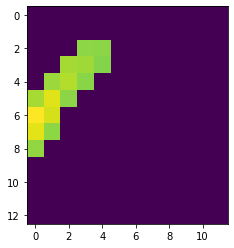

In [81]:
plt.imshow(tmp[n_indices,:][:,ds_indices])

In [82]:
(nlist[1] - nlist[0])*10, (ds[1] - ds[0])*25

(0.14736842105263159, 54.347826086956452)

In [83]:
np.save(METADATA + 'cost_functions_cancer_final.npy', cost_functions)
np.save(METADATA + 'thicknesses_cancer_final.npy', thicknesses)

In [84]:
cost_functions.shape

(96, 1737, 300)

In [85]:
from scipy.signal import argrelextrema, argrelmin
x = np.array([2, 1, 2, 3, 2, 0, 1, 0])
argrelextrema(x, np.greater)

y = np.array([[1, 2, 1, 2],
              [2, 2, 0, 0],
              [5, 3, 4, 4]])

extrema = argrelextrema(y, np.less)
extrema

(array([1, 1]), array([2, 3]))

In [86]:
nx, sx, dx = cost_functions.shape
confidences = np.array([confidence2d(cost_functions[:,i,:],ds,nlist)[0] for i in range(sx)])
pdfs = np.array([confidence2d(cost_functions[:,i,:],ds,nlist)[1] for i in range(sx)])

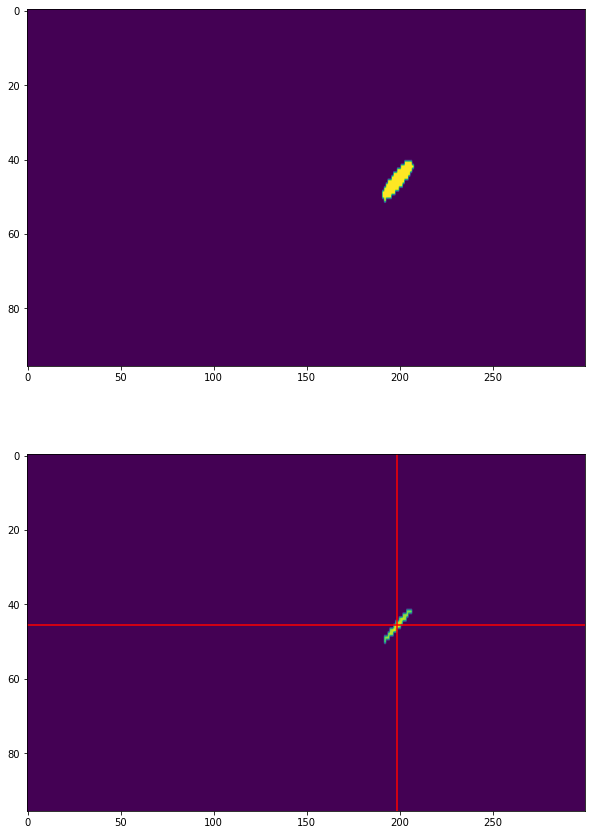

In [87]:
mpl_colors = ['r','g','b','y','c','m','w']
def find_regions(pdf):
    filtered = gaussian_filter(pdf, sigma=1)
    filtered[filtered < 1/1] = 0 
    filtered[filtered > + 1/1] = 1
    labels = measure.label(filtered)
    regions = measure.regionprops(labels,intensity_image=pdf)
    max_coords = []
    max_intens = []
    for region in regions:
        max_coords.append(region.weighted_centroid)
        max_intens.append(region.max_intensity)
    max_coords = np.array(max_coords)
    max_intens = np.array(max_intens)
    args = np.argsort(max_intens)[::-1]
    return max_coords[args], max_intens[args]

idx = np.random.randint(len(pdfs))
pdf = pdfs[idx]
coords, intens = find_regions(pdf)
filtered = gaussian_filter(pdf, sigma=1)
filtered[filtered < 1/1] = 0 
filtered[filtered > + 1/1] = 1
plt.figure(figsize=[10,15])
plt.subplot(211)
plt.imshow(measure.label(filtered),aspect=2)
plt.subplot(212)
plt.imshow(pdf,aspect=2)
for i, xy in enumerate(coords):
    plt.axvline(xy[1],color=mpl_colors[i])
    plt.axhline(xy[0],color=mpl_colors[i])
plt.show()

In [88]:
max_regions = 2
coords = []
for pdf in pdfs:
    coord, _ = find_regions(pdf)
    coords.append(coord[:max_regions])

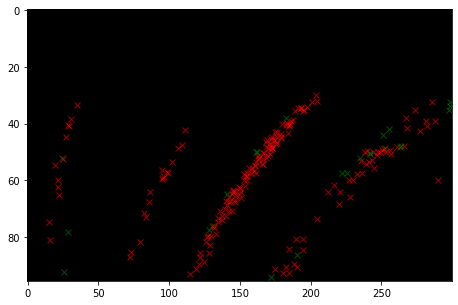

In [93]:
plt.figure(figsize=[10,5])
cluster = 3
confidence_th = 0.8
mask = (confidences > confidence_th) & (cluster_masks[cluster])
plt.imshow(np.zeros_like(pdf),aspect=2,cmap='gray')
for coord in np.array(coords)[mask]:
    for i, xy in enumerate(coord):
        plt.plot(xy[1],xy[0],color=mpl_colors[i],marker='x',alpha=0.6)
plt.show()

  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 2782, in stem
    'In Matplotlib 3.3 individual lines on a stem plot will be '
  File "/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 1993, in _warn_external
    warnings.warn(message, category, stacklevel)
/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


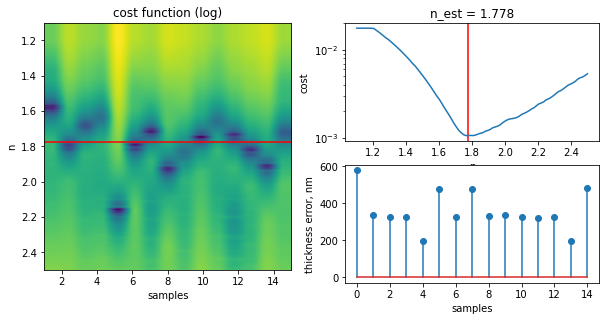

In [102]:
def plot_cost(cost, cluster=0, confidence_th=0, nlist = nlist, ds = ds, confidences=confidences):
    mask = (confidences > confidence_th) & (cluster_masks[cluster])
    cluster_samples = samples[mask]
    tmp = cost[:,mask].mean(axis=1)
    ibest = cost[:,mask].mean(axis=1).argmin()
    nest = nlist[cost[:,mask].mean(axis=1).argmin()]
    plt.figure(figsize=[10,10])
    plt.subplot(221)
    plt.title('cost function (log)')
    plt.imshow(np.log(cost[:,mask]),aspect=len(cluster_samples)//(max(nlist)-min(nlist)),extent=[1,len(cluster_samples),nlist.max(),nlist.min()])
    plt.axhline(nest,color='r')
    plt.xlabel('samples')
    plt.ylabel('n')
    plt.subplot(422)
    plt.title('n_est = %.3f' % (nest))
    plt.axvline(nest,color='r', label='estimated refractive')
    plt.plot(nlist,tmp)
    plt.xlabel("n")
    plt.ylabel('cost')
    plt.yscale('log')
    plt.subplot(424)
    #plt.plot(np.abs(gt_thicknesses-thicknesses[ibest]), )
    plt.stem(thicknesses[:,mask][ibest])
    plt.xlabel("samples")
    plt.ylabel("thickness error, nm")
    plt.show()
    return ibest, nest

pooled_cost_functions = cost_functions.min(axis=-1)
ibest, nest = plot_cost(pooled_cost_functions,confidence_th=0.99,cluster=0)

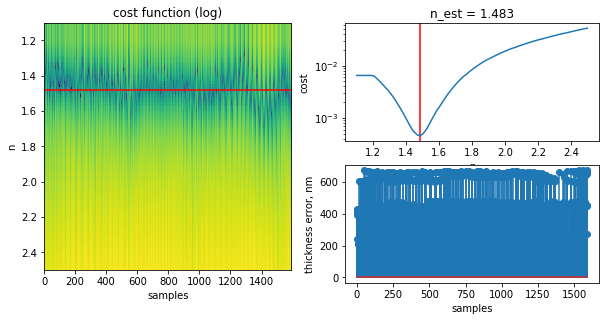

In [1973]:
cluster = 1
cluster_samples = samples[cluster_masks[cluster]]
tmp = pooled_cost_functions[:,cluster_masks[cluster]].mean(axis=1)
ibest = pooled_cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()
nest = nlist[pooled_cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()]
plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('cost function (log)')
plt.imshow(np.log(pooled_cost_functions[:,cluster_masks[cluster]]),aspect=len(cluster_samples)//(max(nlist)-min(nlist)),extent=[1,len(cluster_samples),nlist.max(),nlist.min()])
plt.axhline(nest,color='r')
plt.xlabel('samples')
plt.ylabel('n')
plt.subplot(422)
plt.title('n_est = %.3f' % (nest))
plt.axvline(nest,color='r', label='estimated refractive')
plt.plot(nlist,tmp)
plt.xlabel("n")
plt.ylabel('cost')
plt.yscale('log')
plt.subplot(424)
#plt.plot(np.abs(gt_thicknesses-thicknesses[ibest]), )
plt.stem(thicknesses[:,cluster_masks[cluster]][ibest])
plt.xlabel("samples")
plt.ylabel("thickness error, nm")
plt.show()

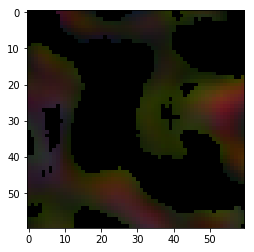

In [2038]:
show_cluster(labels,colors,cluster=4)

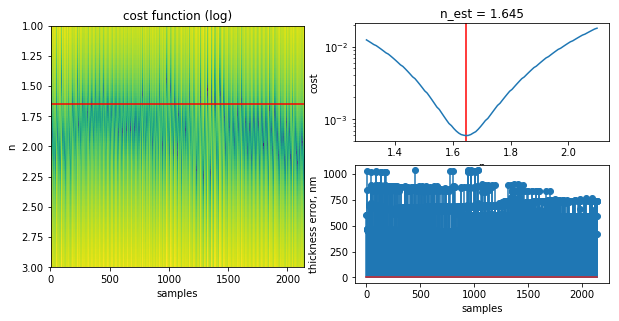

In [79]:
cluster = 1
cluster_samples = samples[cluster_masks[cluster]]
tmp = cost_functions[:,cluster_masks[cluster]].mean(axis=1)
ibest = cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()
nest = nlist[cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()]
plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('cost function (log)')
plt.imshow(np.log(cost_functions[:,cluster_masks[cluster]]),aspect=len(cluster_samples)//max(nlist),extent=[1,len(cluster_samples),3,1])
plt.axhline(nest,color='r')
plt.xlabel('samples')
plt.ylabel('n')
plt.subplot(422)
plt.title('n_est = %.3f' % (nest))
plt.axvline(nest,color='r', label='estimated refractive')
plt.plot(nlist,tmp)
plt.xlabel("n")
plt.ylabel('cost')
plt.yscale('log')
plt.subplot(424)
#plt.plot(np.abs(gt_thicknesses-thicknesses[ibest]), )
plt.stem(thicknesses[:,cluster_masks[cluster]][ibest])
plt.xlabel("samples")
plt.ylabel("thickness error, nm")
plt.show()

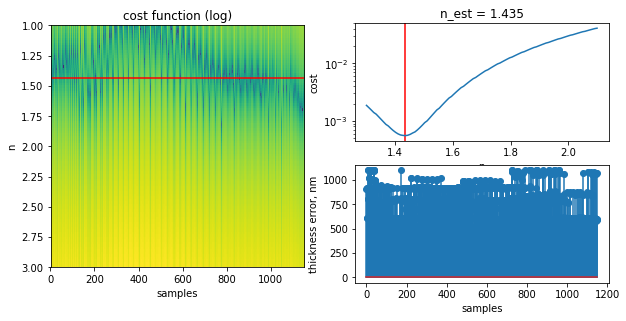

In [80]:
cluster = 0
cluster_samples = samples[cluster_masks[cluster]]
tmp = cost_functions[:,cluster_masks[cluster]].mean(axis=1)
ibest = cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()
nest = nlist[cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()]
plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('cost function (log)')
plt.imshow(np.log(cost_functions[:,cluster_masks[cluster]]),aspect=len(cluster_samples)//max(nlist),extent=[1,len(cluster_samples),3,1])
plt.axhline(nest,color='r')
plt.xlabel('samples')
plt.ylabel('n')
plt.subplot(422)
plt.title('n_est = %.3f' % (nest))
plt.axvline(nest,color='r', label='estimated refractive')
plt.plot(nlist,tmp)
plt.xlabel("n")
plt.ylabel('cost')
plt.yscale('log')
plt.subplot(424)
#plt.plot(np.abs(gt_thicknesses-thicknesses[ibest]), )
plt.stem(thicknesses[:,cluster_masks[cluster]][ibest])
plt.xlabel("samples")
plt.ylabel("thickness error, nm")
plt.show()

In [83]:
cluster = 0
ibest1 = cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()
cluster = 1
ibest2 = cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()
cluster = 2
ibest3 = cost_functions[:,cluster_masks[cluster]].mean(axis=1).argmin()

In [96]:
thickness_map = np.zeros(colors.shape[:2])
refr_index_map = np.zeros(colors.shape[:2])
clean_map = thickness_map[~bg_mask]
refr_clean_map = refr_index_map[~bg_mask]
#thickness_map = thicknesses[[ibest1,ibest2,ibest3]]
for i, mask in enumerate(cluster_masks):
    clear_output(wait=2)
    ibest, nest = plot_cost(pooled_cost_functions,confidence_th=0.9,cluster=i)
    clean_map[mask] = thicknesses[ibest,cluster_masks[i]]
    refr_clean_map[mask] = np.ones_like(labels[~bg_mask][mask]) * nest 
thickness_map[~bg_mask] = clean_map.copy()
refr_index_map[~bg_mask] = refr_clean_map.copy()
plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('image')
plt.imshow(colors)
plt.subplot(222)
plt.title('clusters')
plt.imshow(labels)
plt.subplot(223)
plt.title('thickness')
plt.imshow(thickness_map)
plt.subplot(224)
plt.title('refractive index')
plt.imshow(refr_index_map)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [68]:
from IPython.display import clear_output

In [88]:
np.save('refr_index_map.npy',refr_index_map)
np.save('thickness_map.npy',thickness_map)
np.save('labels_map.npy',labels)
np.save('colors_map.npy',labels)